# Spatial Analysis

SpatialTis provides a series of Spatial Anlaysis methods:

- **Find cell neighbors**
- **Neighbor dependent markers**

**Cell type based analysis**:

- **Spatial Distribution***
- **Spatial Heterogenenity***
- **Hotspot Detection***
- **Neighborhood Analyisis (Cell-Cell Interaction)**

\* No need to compute neighbors information

Markers based analysis:

- Spatial Enrichment Analysis (Markers spatial enrichemnt)
- Spatial Co-expression
- Spatial community detection

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import anndata as ad

data = ad.read_h5ad("../data/imc_data.h5ad")
data

AnnData object with n_obs × n_vars = 1776974 × 38
    obs: 'area', 'eccentricity', 'islet_id', 'centroid', 'image', 'case', 'slide', 'part', 'group', 'stage', 'cell_cat', 'cell_type'
    var: 'markers'

This is a huge dataset, almost 1.8 millions of cell

In [3]:
import spatialtis as st
import spatialtis.plotting as sp
from spatialtis import CONFIG

CONFIG.EXP_OBS = ["stage", "case", "part", "image"] 
CONFIG.CELL_TYPE_KEY = "cell_type" 
CONFIG.MARKER_KEY = "markers"
CONFIG.CENTROID_KEY = "centroid"

Since this is a diabetic data, we mainly focus on islets cells. If you are interesated in the immune part, feel free to look into it yourself.

In [4]:
islets_cells = ['gamma', 'delta', 'alpha', 'beta']
group_order={"stage":["Non-diabetic", "Onset", "Long-duration"]}

## Spatial Distribution

There are three type of distribution pattern (0 if no cells)

- Random (1)
- Regular (2)
- Cluster (3)

Three methods are provided

- Variance-to-mean ratio (**vmr**): Index of Dispersion
- Quadratic statistics (**quad**): Morisita’s index of dispersion
- Nearest neighbors search (**nns**): Clark and Evans aggregation index

Two visualizations:

- Dot plot
- Heatmap

In [5]:
st.spatial_distribution(data) # default: method="nns"
# st.spatial_distribution(data, method="vmr")

Finding distribution pattern ██████████ 100% 00:00|00:08


In [39]:
# st.spatial_distribution(data, export_key="nns")
st.spatial_distribution(data, r=20, method="vmr", pval=0.001, export_key="vmr")
# st.spatial_distribution(data, quad=(8, 8), method="quad", export_key="quad")

Finding distribution pattern ██████████ 100% 00:00|00:07


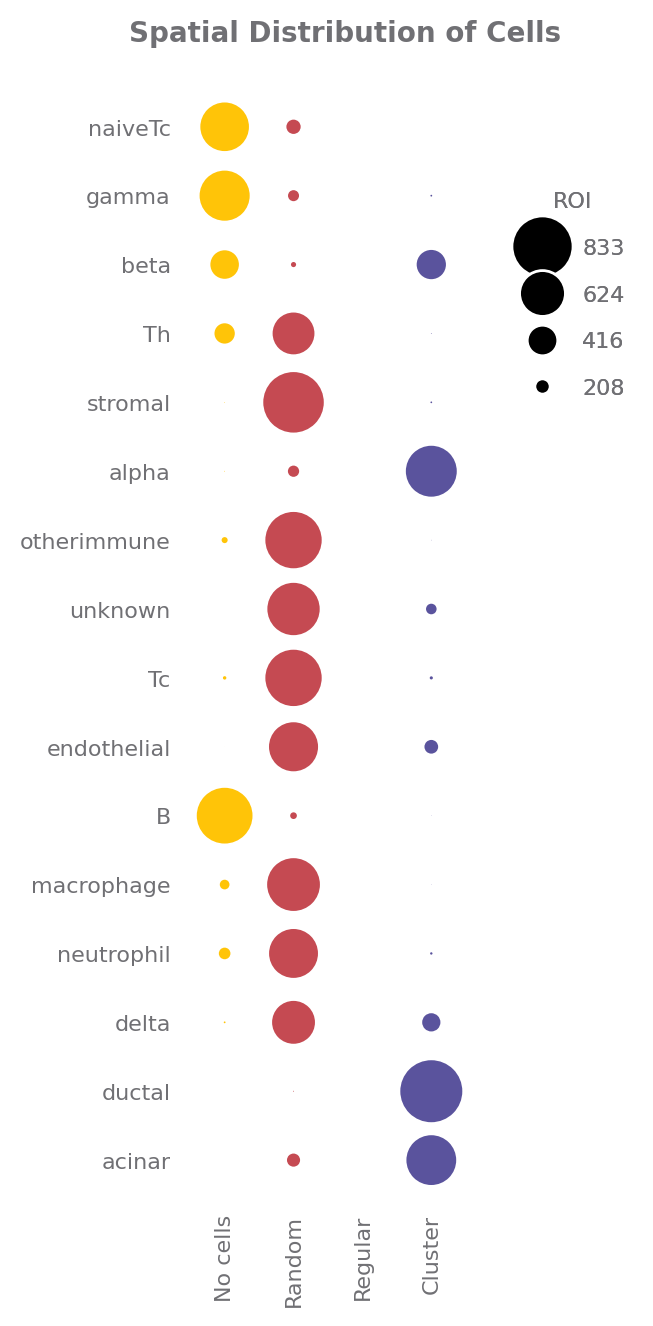

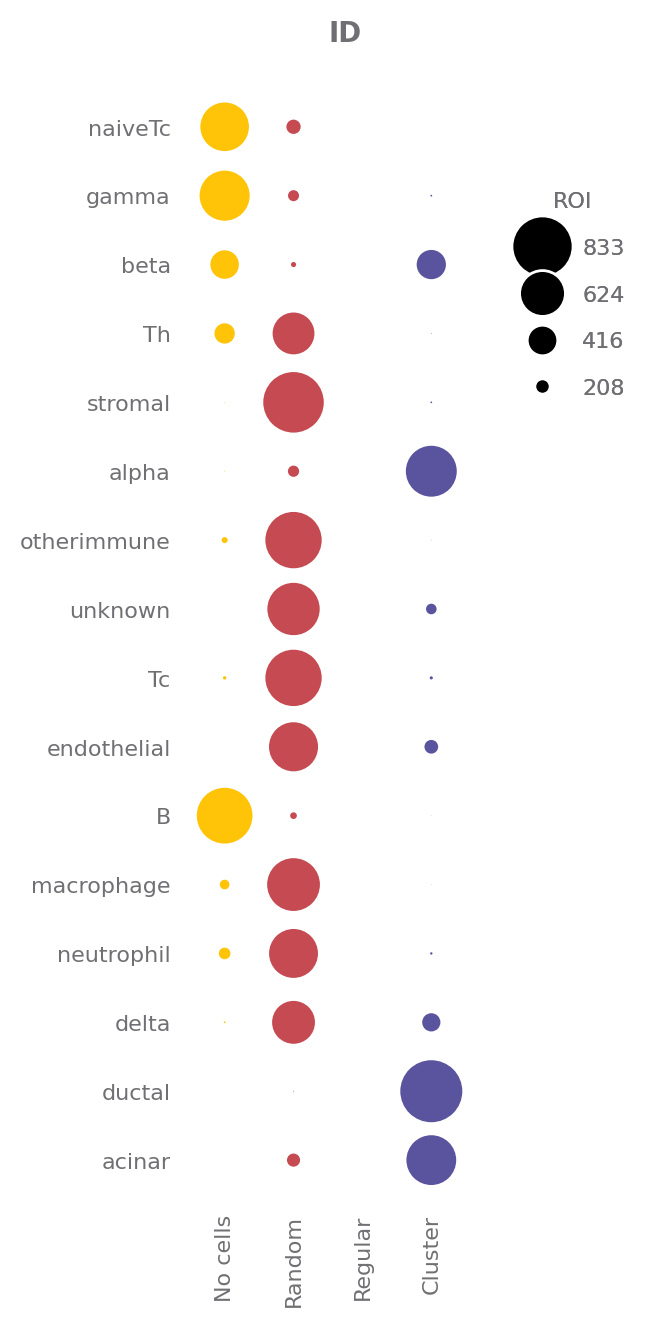

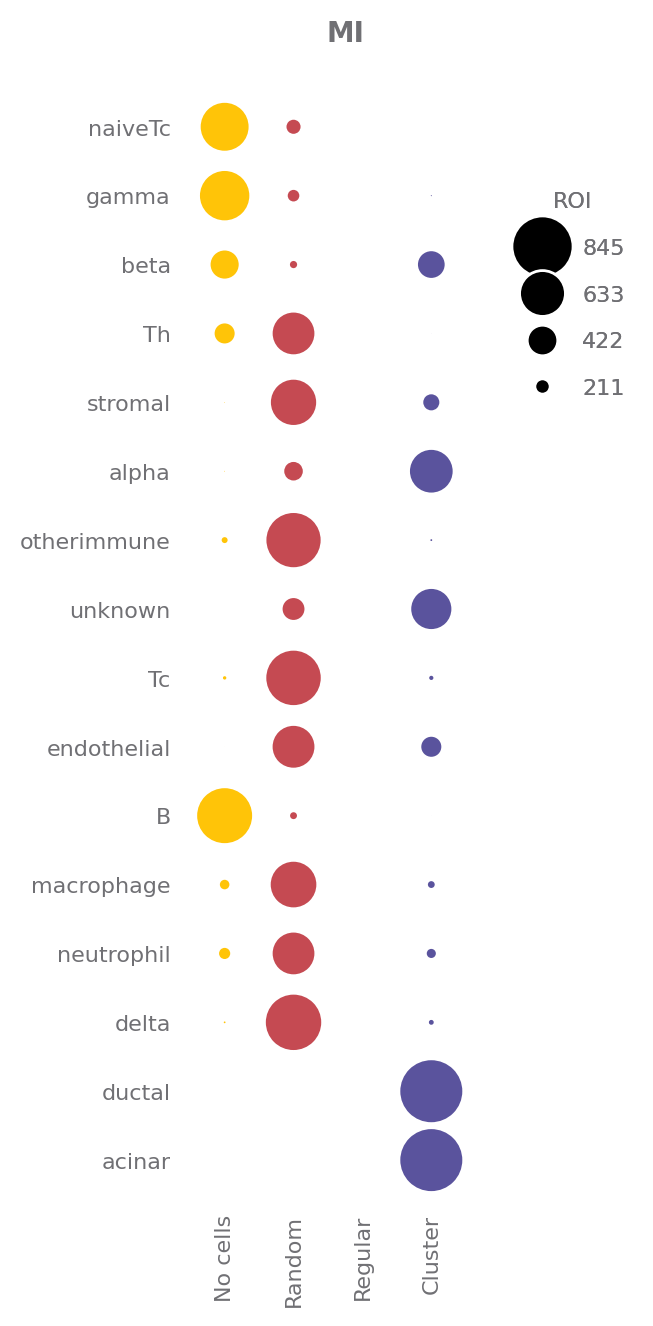

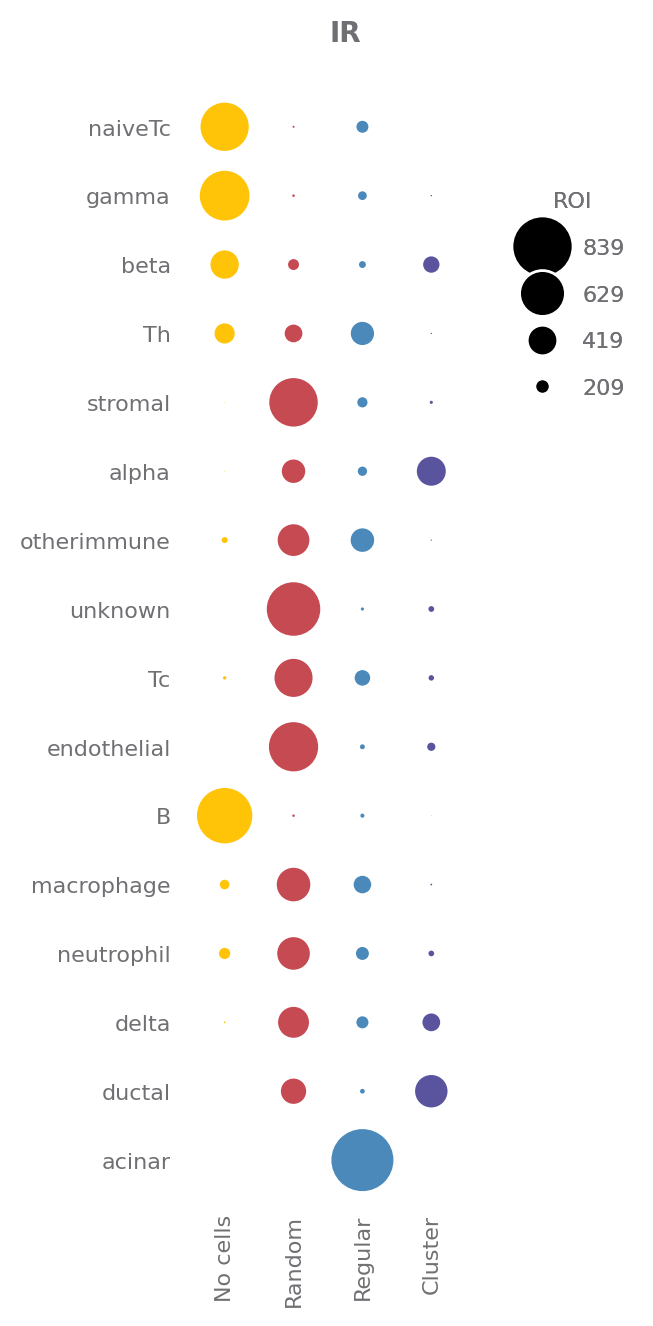

In [53]:
sp.spatial_distribution(data, key="vmr", title="Spatial Distribution of Cells")
sp.spatial_distribution(data, key="vmr", title="ID")
sp.spatial_distribution(data, key="quad", title="MI")
sp.spatial_distribution(data, key="nns", title="IR")

In [52]:
df = st.get_result(data, 'vmr')
df[(df['image'] == 'Q01')]

stage  case  part image         type  pattern
0   Long-duration  6089  Body   Q01       acinar        3
1   Long-duration  6089  Body   Q01       ductal        3
2   Long-duration  6089  Body   Q01        delta        1
3   Long-duration  6089  Body   Q01   neutrophil        1
4   Long-duration  6089  Body   Q01   macrophage        1
5   Long-duration  6089  Body   Q01            B        0
6   Long-duration  6089  Body   Q01  endothelial        1
7   Long-duration  6089  Body   Q01           Tc        1
8   Long-duration  6089  Body   Q01      unknown        1
9   Long-duration  6089  Body   Q01  otherimmune        1
10  Long-duration  6089  Body   Q01        alpha        3
11  Long-duration  6089  Body   Q01      stromal        1
12  Long-duration  6089  Body   Q01           Th        1
13  Long-duration  6089  Body   Q01         beta        0
14  Long-duration  6089  Body   Q01        gamma        0
15  Long-duration  6089  Body   Q01      naiveTc        0

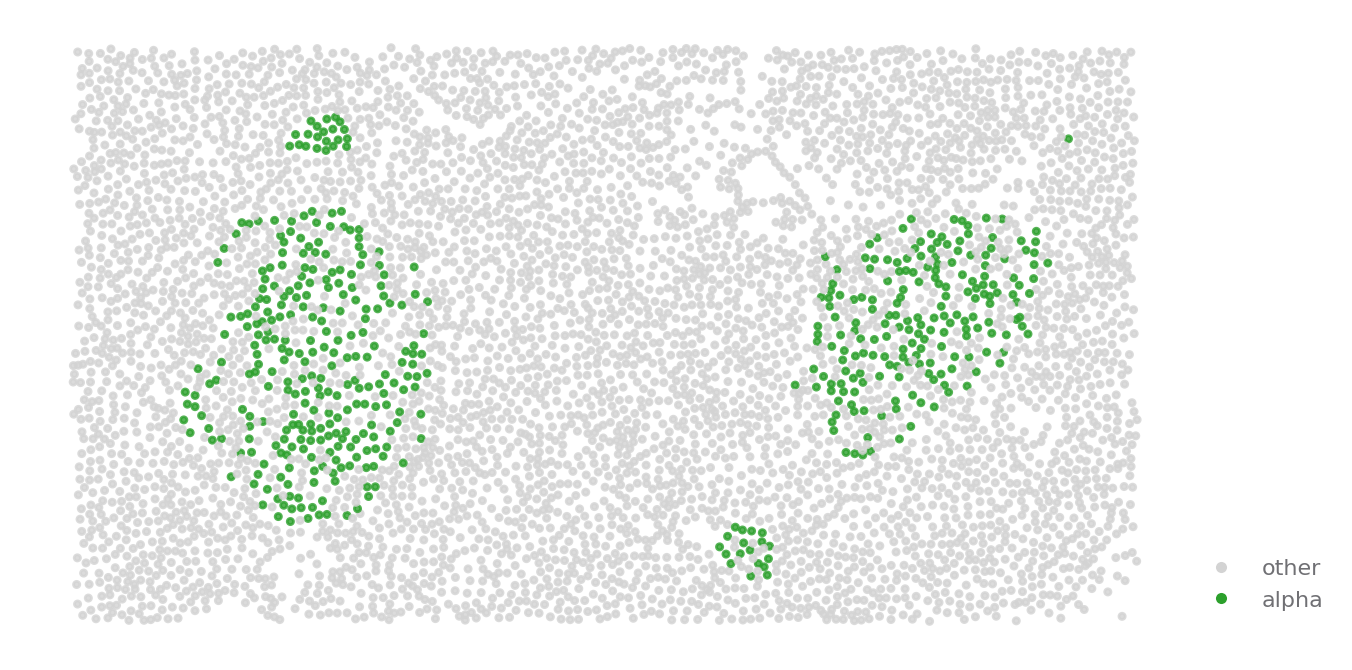

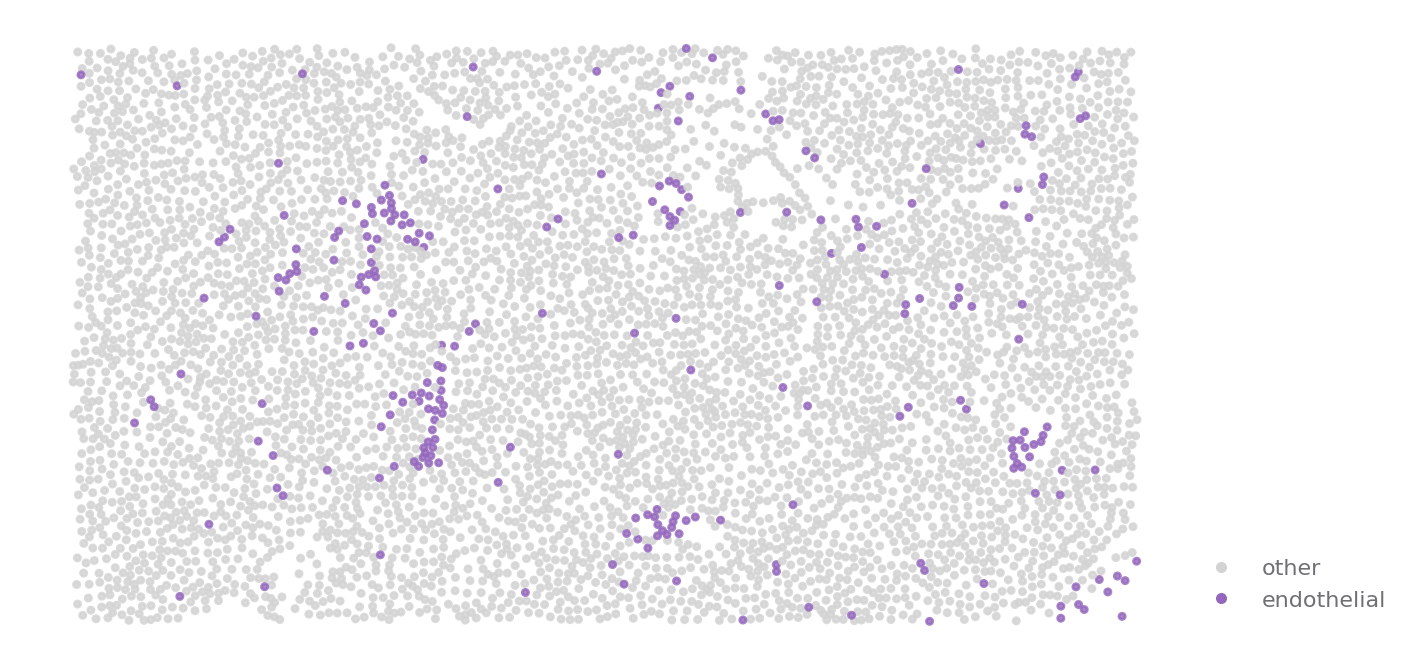

In [55]:
sp.cell_map(data, {"image":"G01"}, selected_types=['alpha'])
sp.cell_map(data, {"image":"G01"}, selected_types=['endothelial'])

In [47]:
st.hotspot(data, selected_types=['ductal'], export_key="ductal")

Hotspot analysis ██████████ 100% 00:00|00:00


Or you could visualize it in heatmap

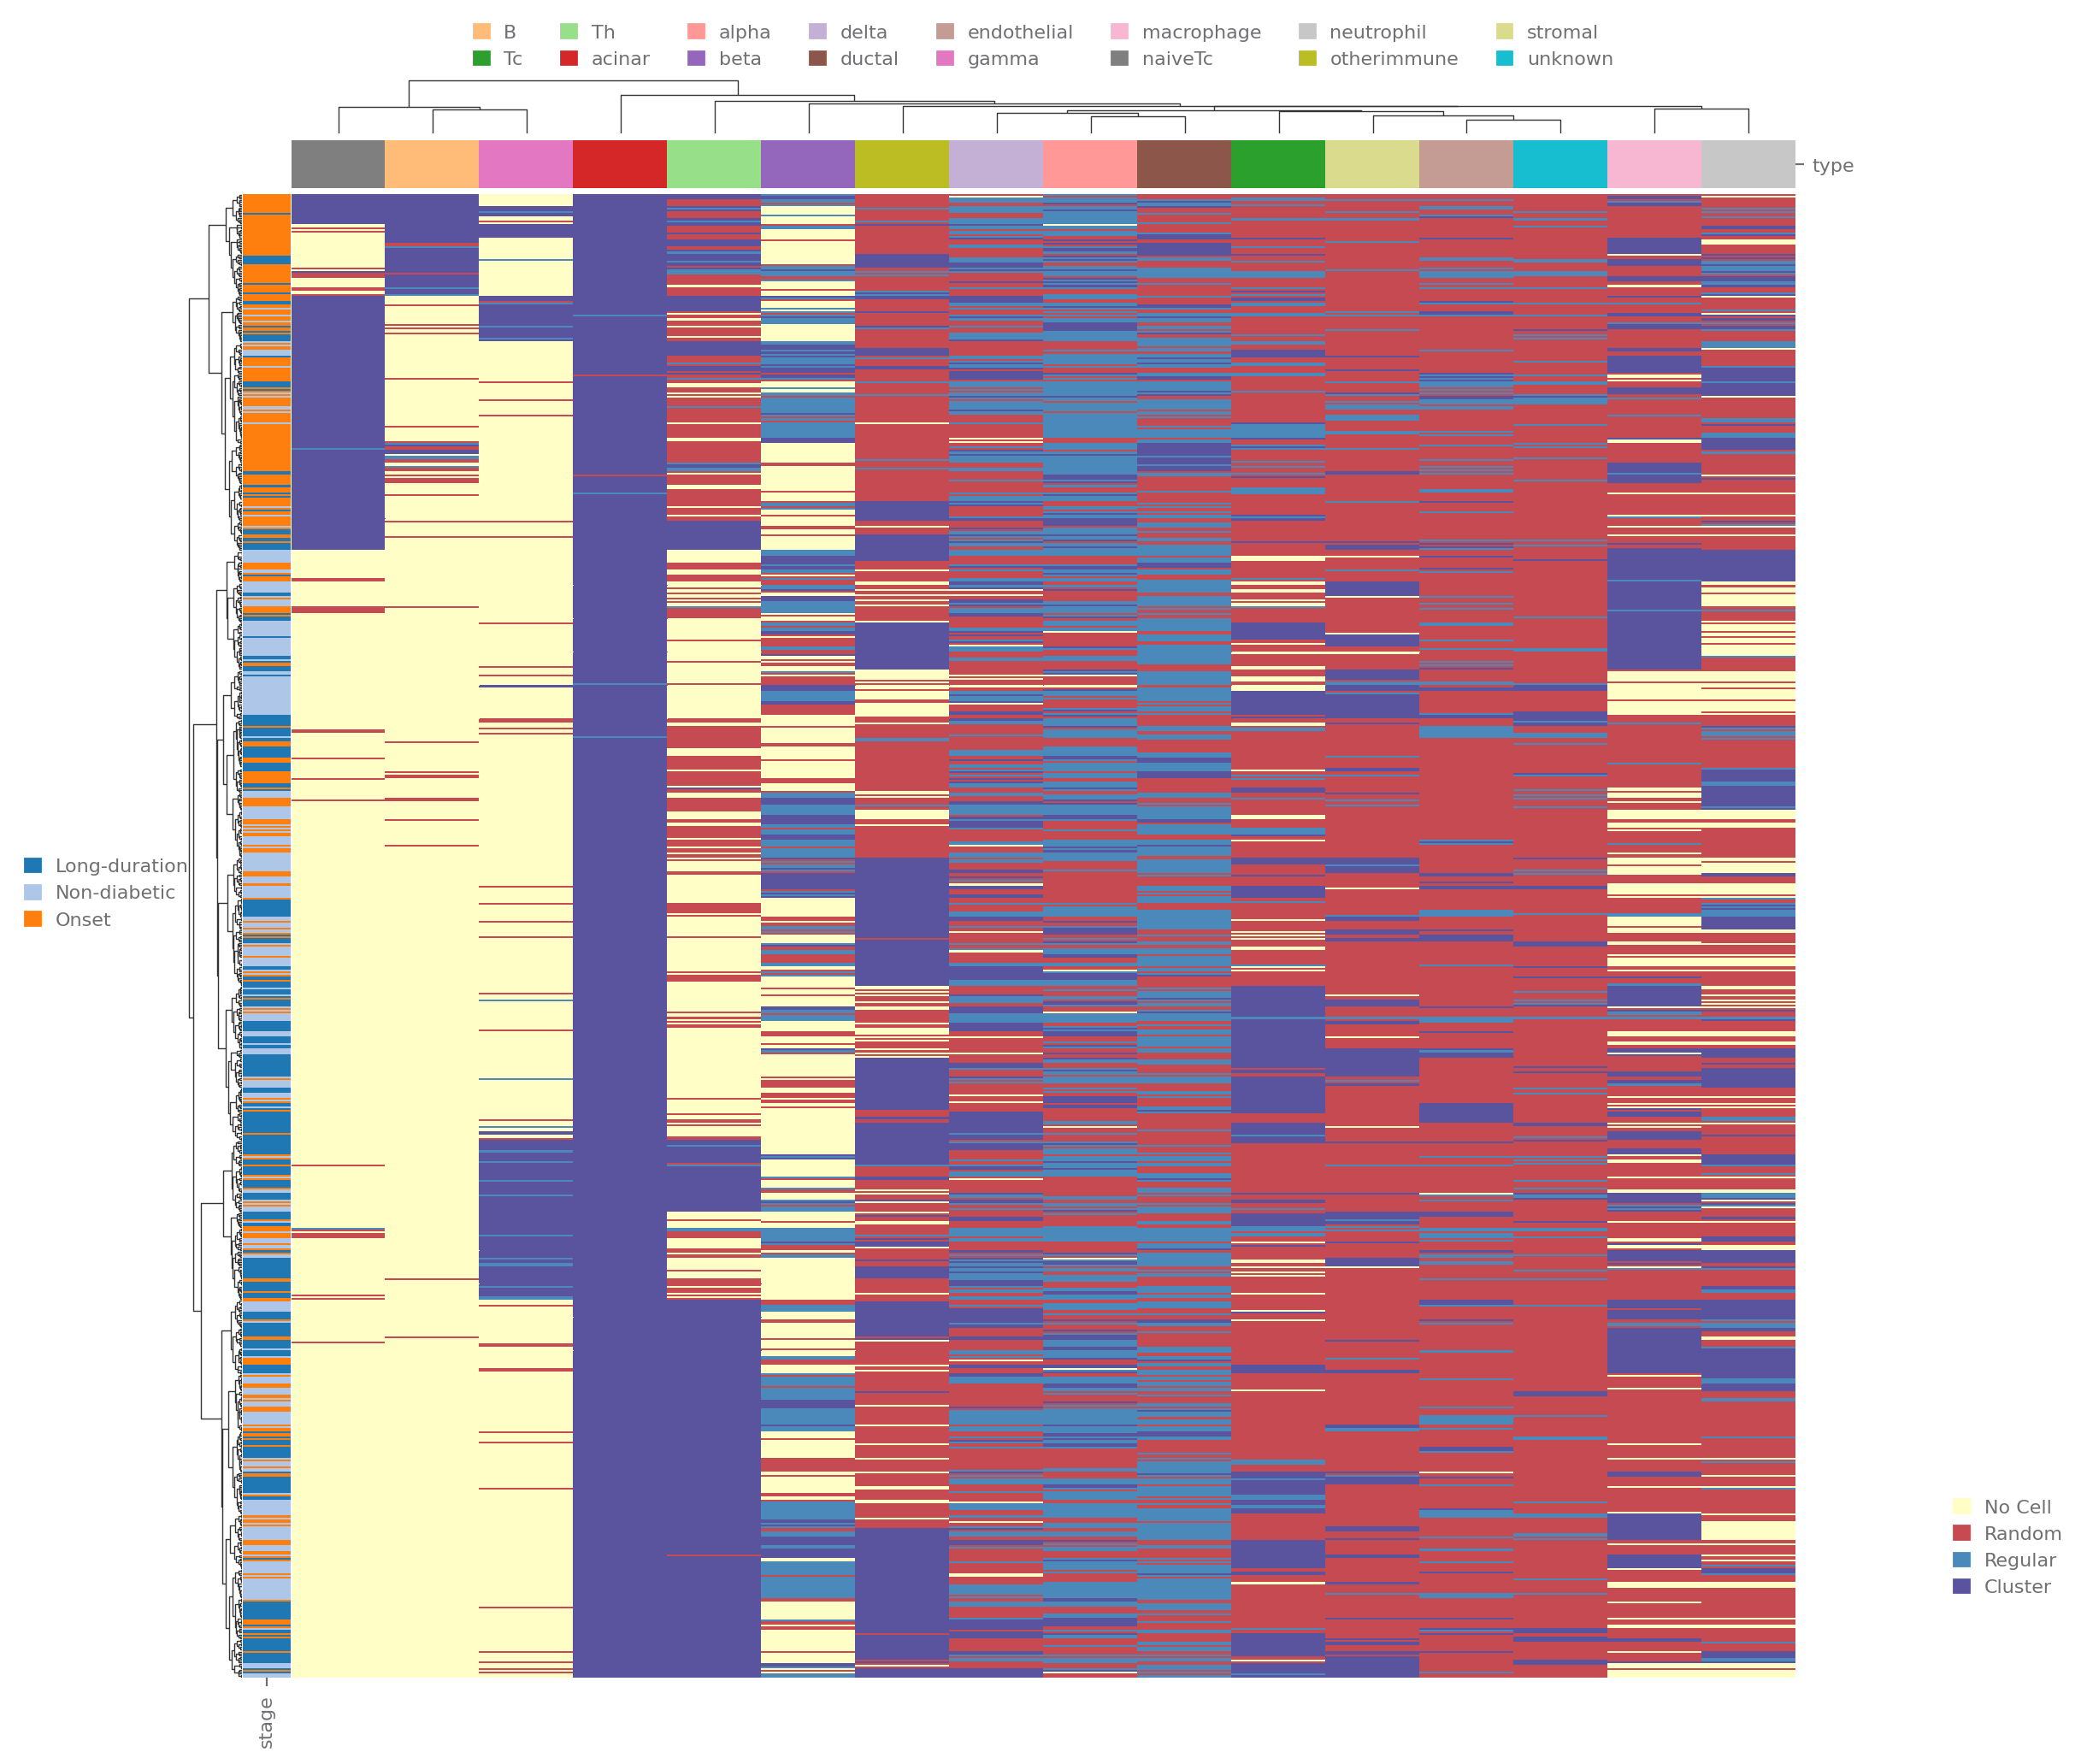

In [8]:
sp.spatial_distribution(data, groupby=['stage'], use="heatmap", clustermap_kwargs=dict(row_cluster=True))

## Spatial Heterogeneity

Used to evaluate the tissue heterogeneity

Three methods are provided:

- Shannon entropy (No spatial information)
- Leibovici entropy (Spatial entropy)
- Altieri entropy (Spatial entropy)

The number of three species are the same in three figures, You can see that shannon entropy remain the same. Only spatial entropy is changing.

![entropy-diff](https://github.com/Mr-Milk/SpatialEntropy/raw/master/src/example.png)

In [8]:
st.spatial_heterogeneity(data, method="shannon", export_key="shannon")
st.spatial_heterogeneity(data, export_key="lei")
st.spatial_heterogeneity(data, method="altieri", export_key="alt")

Calculating heterogeneity ██████████ 100% 00:00|00:01


Calculating heterogeneity ██████████ 100% 00:00|00:30


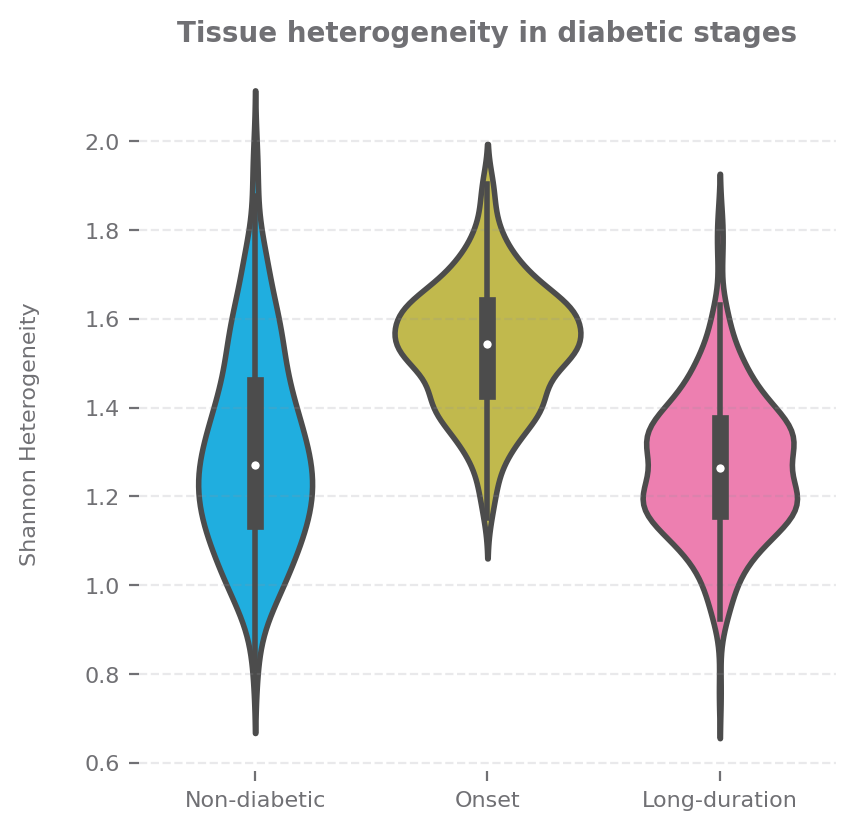

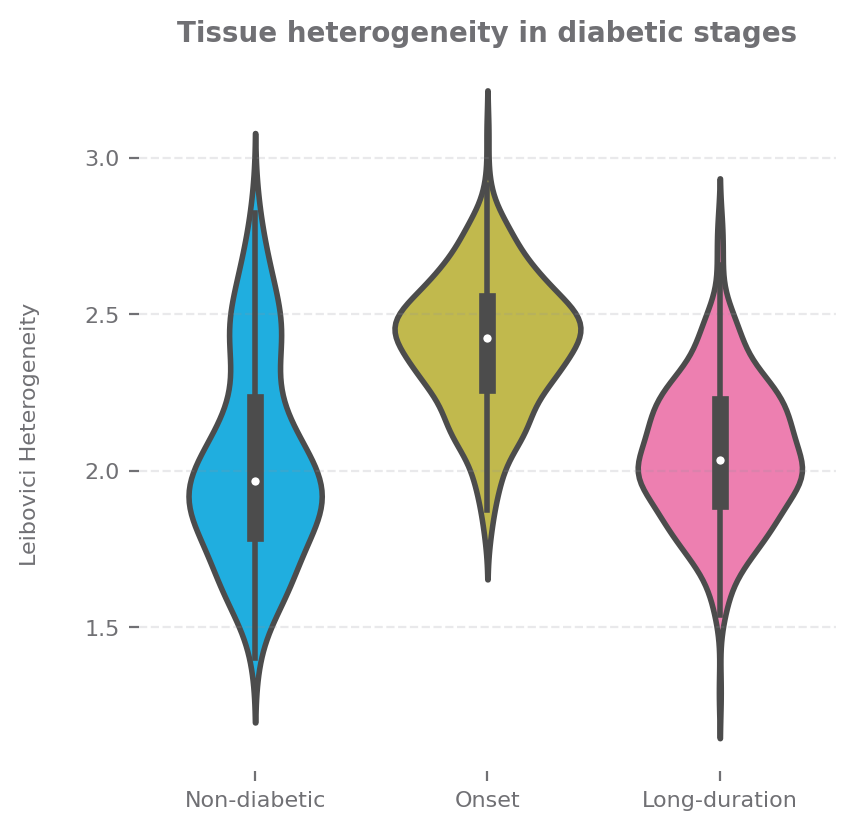

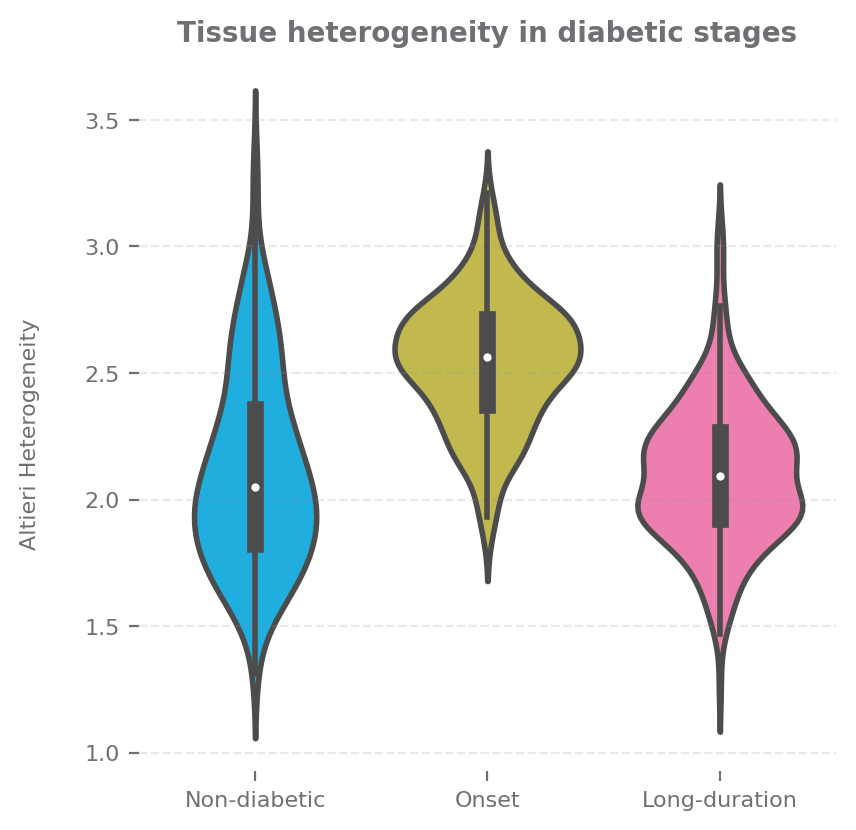

In [9]:
sp.spatial_heterogeneity(data, ['stage'], key="shannon", size=(4, 4), 
                         group_order=group_order,
                         title="Tissue heterogeneity in diabetic stages",
                        yaxis_title="Shannon Heterogeneity")
sp.spatial_heterogeneity(data, ['stage'], key="lei", size=(4, 4), 
                         group_order=group_order,
                         title="Tissue heterogeneity in diabetic stages",
                        yaxis_title="Leibovici Heterogeneity")
sp.spatial_heterogeneity(data, ['stage'], key="alt", size=(4, 4), 
                         group_order=group_order,
                         title="Tissue heterogeneity in diabetic stages",
                        yaxis_title="Altieri Heterogeneity")

In [42]:
st.spatial_heterogeneity(data)

Calculating heterogeneity ██████████ 100% 00:00|00:01


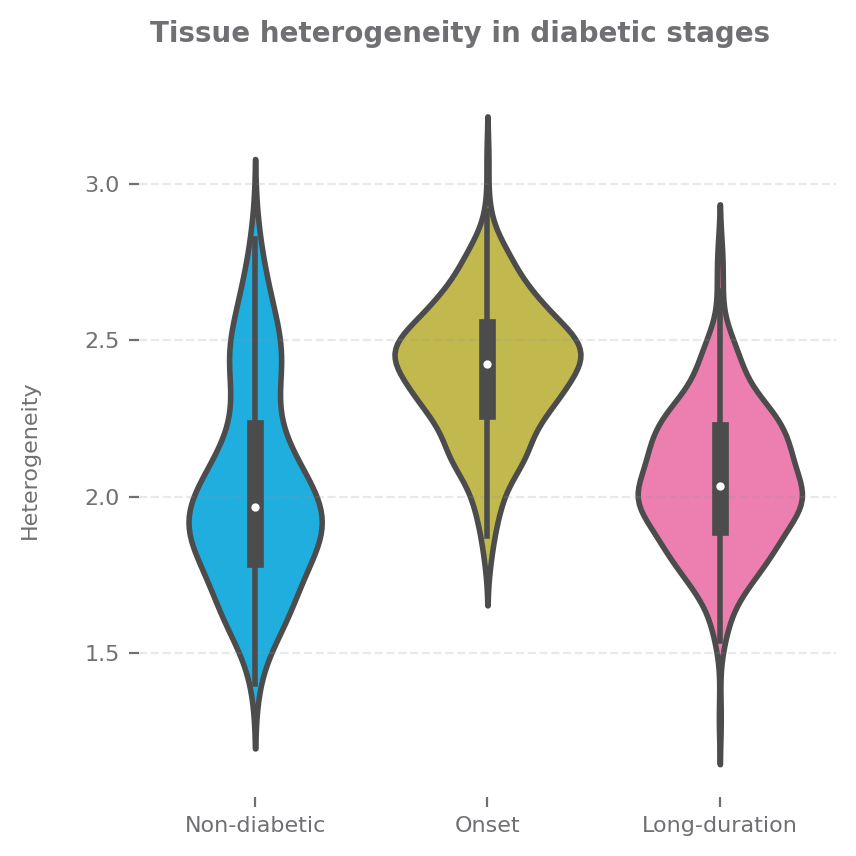

In [45]:
sp.spatial_heterogeneity(data, ['stage'], size=(4, 4), 
                         group_order=group_order,
                         title="Tissue heterogeneity in diabetic stages",
                        yaxis_title="Heterogeneity")

If we look at cell components, we could see that the cell type are more divese in **Onset** stage

In [26]:
st.cell_components(data)

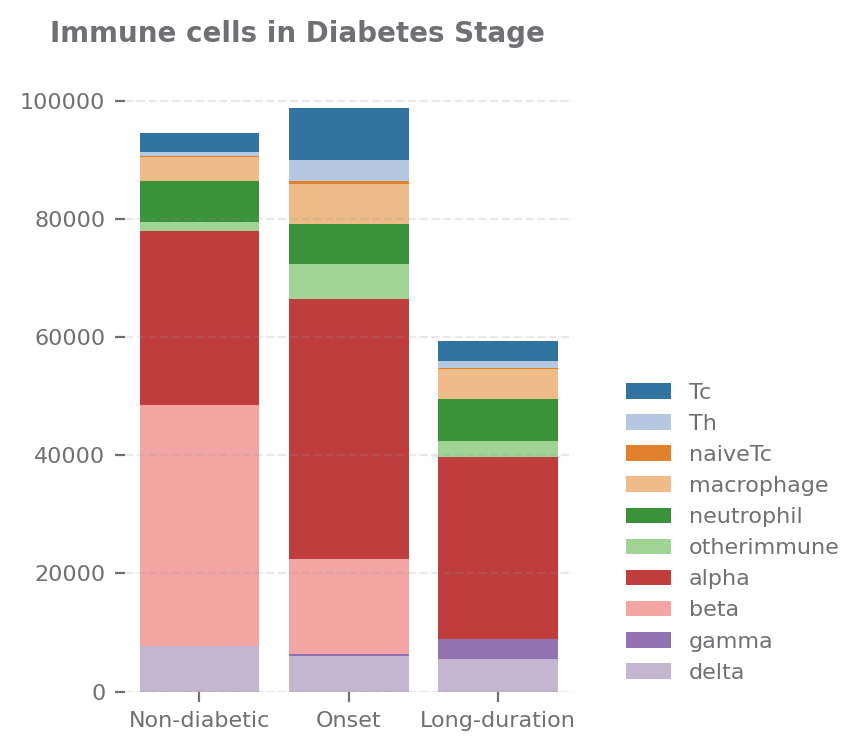

In [60]:
cells = ['Tc', 'Th', 'naiveTc', 'macrophage', 'neutrophil', 'otherimmune', 'alpha', 'beta', 'gamma', 'delta']
sp.cell_components(data, ['stage'], agg="mean", percentage=False, selected_types=cells, group_order=group_order, size=(3,3.5), 
                  title="Immune cells in Diabetes Stage")

## Hotspot detection

Spatial distribution tells you if a cell is clustered, hotspot detection tells you which cells are clustered.

In [24]:
st.hotspot(data, selected_types=islets_cells)

Hotspot analysis ██████████ 100% 00:00|00:00


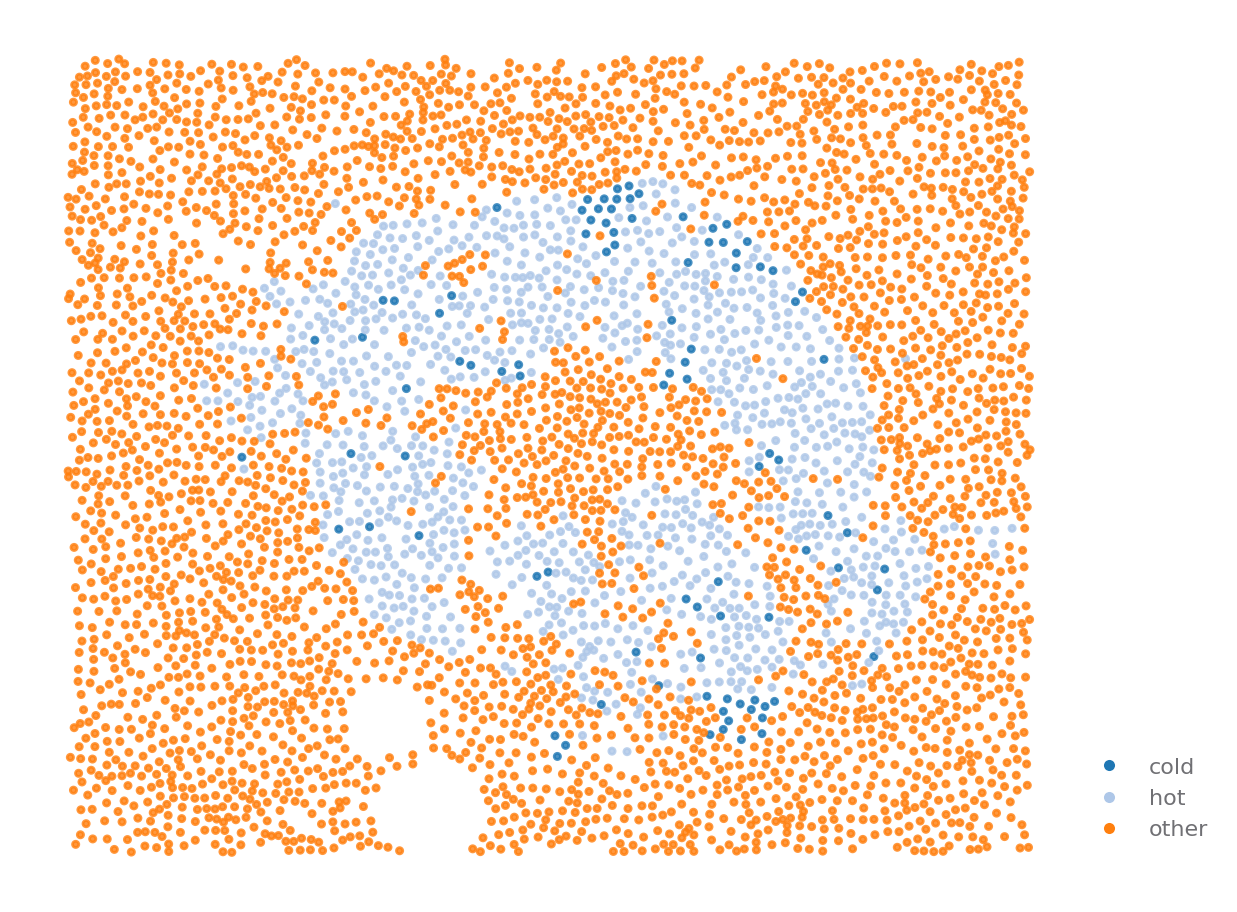

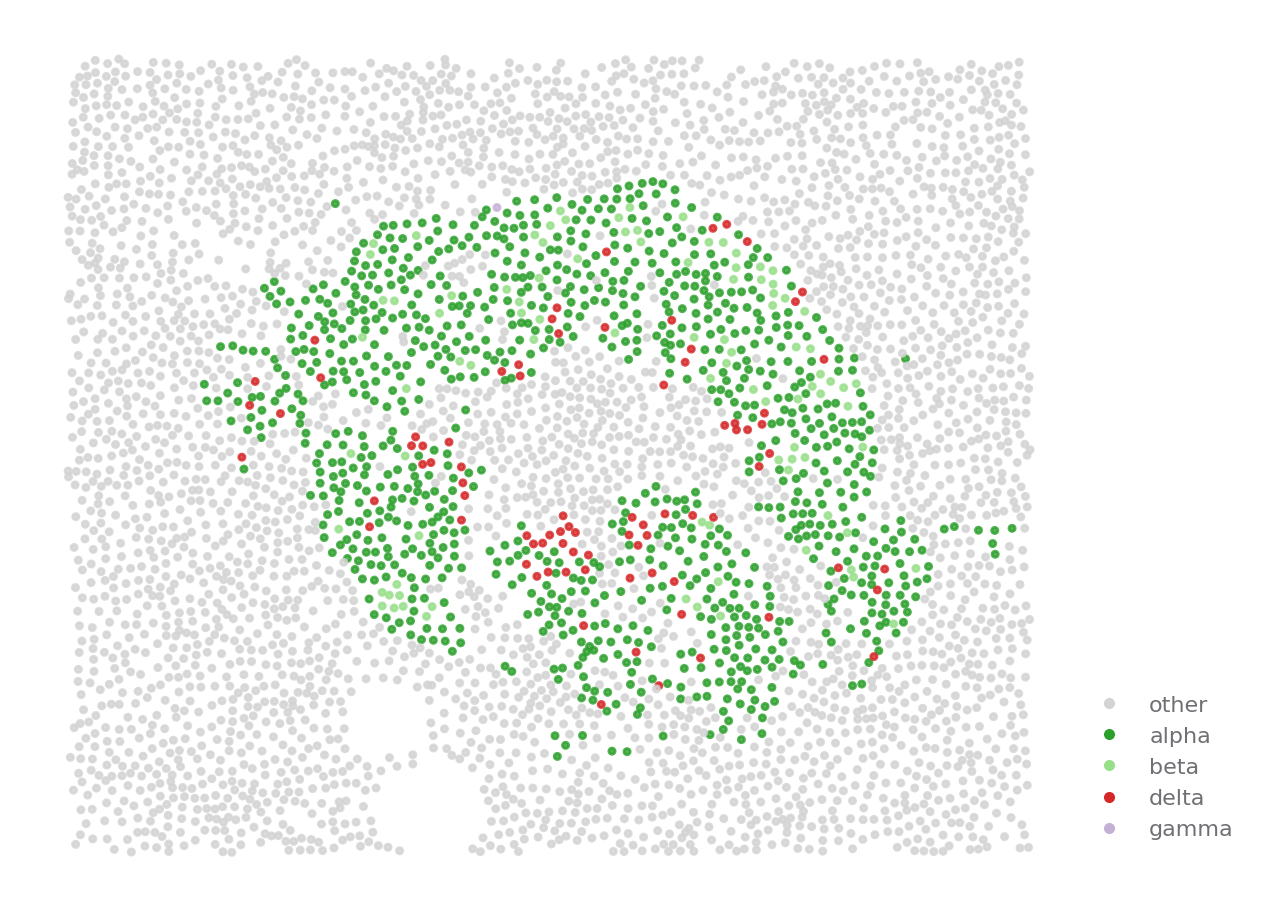

In [25]:
ROI = {"stage": "Onset", "image": "A01"}
sp.cell_map(data, ROI, cell_type_key="hotspot")
sp.cell_map(data, ROI, selected_types=islets_cells)

## Find cell neighbors

Every analysis below will rely on this step. This is a critical step.

Two methods are provided:

- **KD-tree**: If your cells are **points**
- **R-tree**: If your cells are **polygons**

This method is implemented in Rust, it's much faster even that scipy's implementation of KD-tree in C

This dataset only contains points information.

In [46]:
st.find_neighbors(data, expand=8)

Find neighbors ██████████ 100% 00:00|00:14


## Neighborhood Analysis

To profile the cell-cell interaction

This method is also implemented in Rust, see how fast it is.

Three viusalizations:

- Dot matrix plot
- Heatmap
- Graph (static / interactive)

In [47]:
st.neighborhood_analysis(data)

Neighborhood analysis ██████████ 100% 00:00|00:22


In [ ]:
sp.neighborhood_analysis(data)

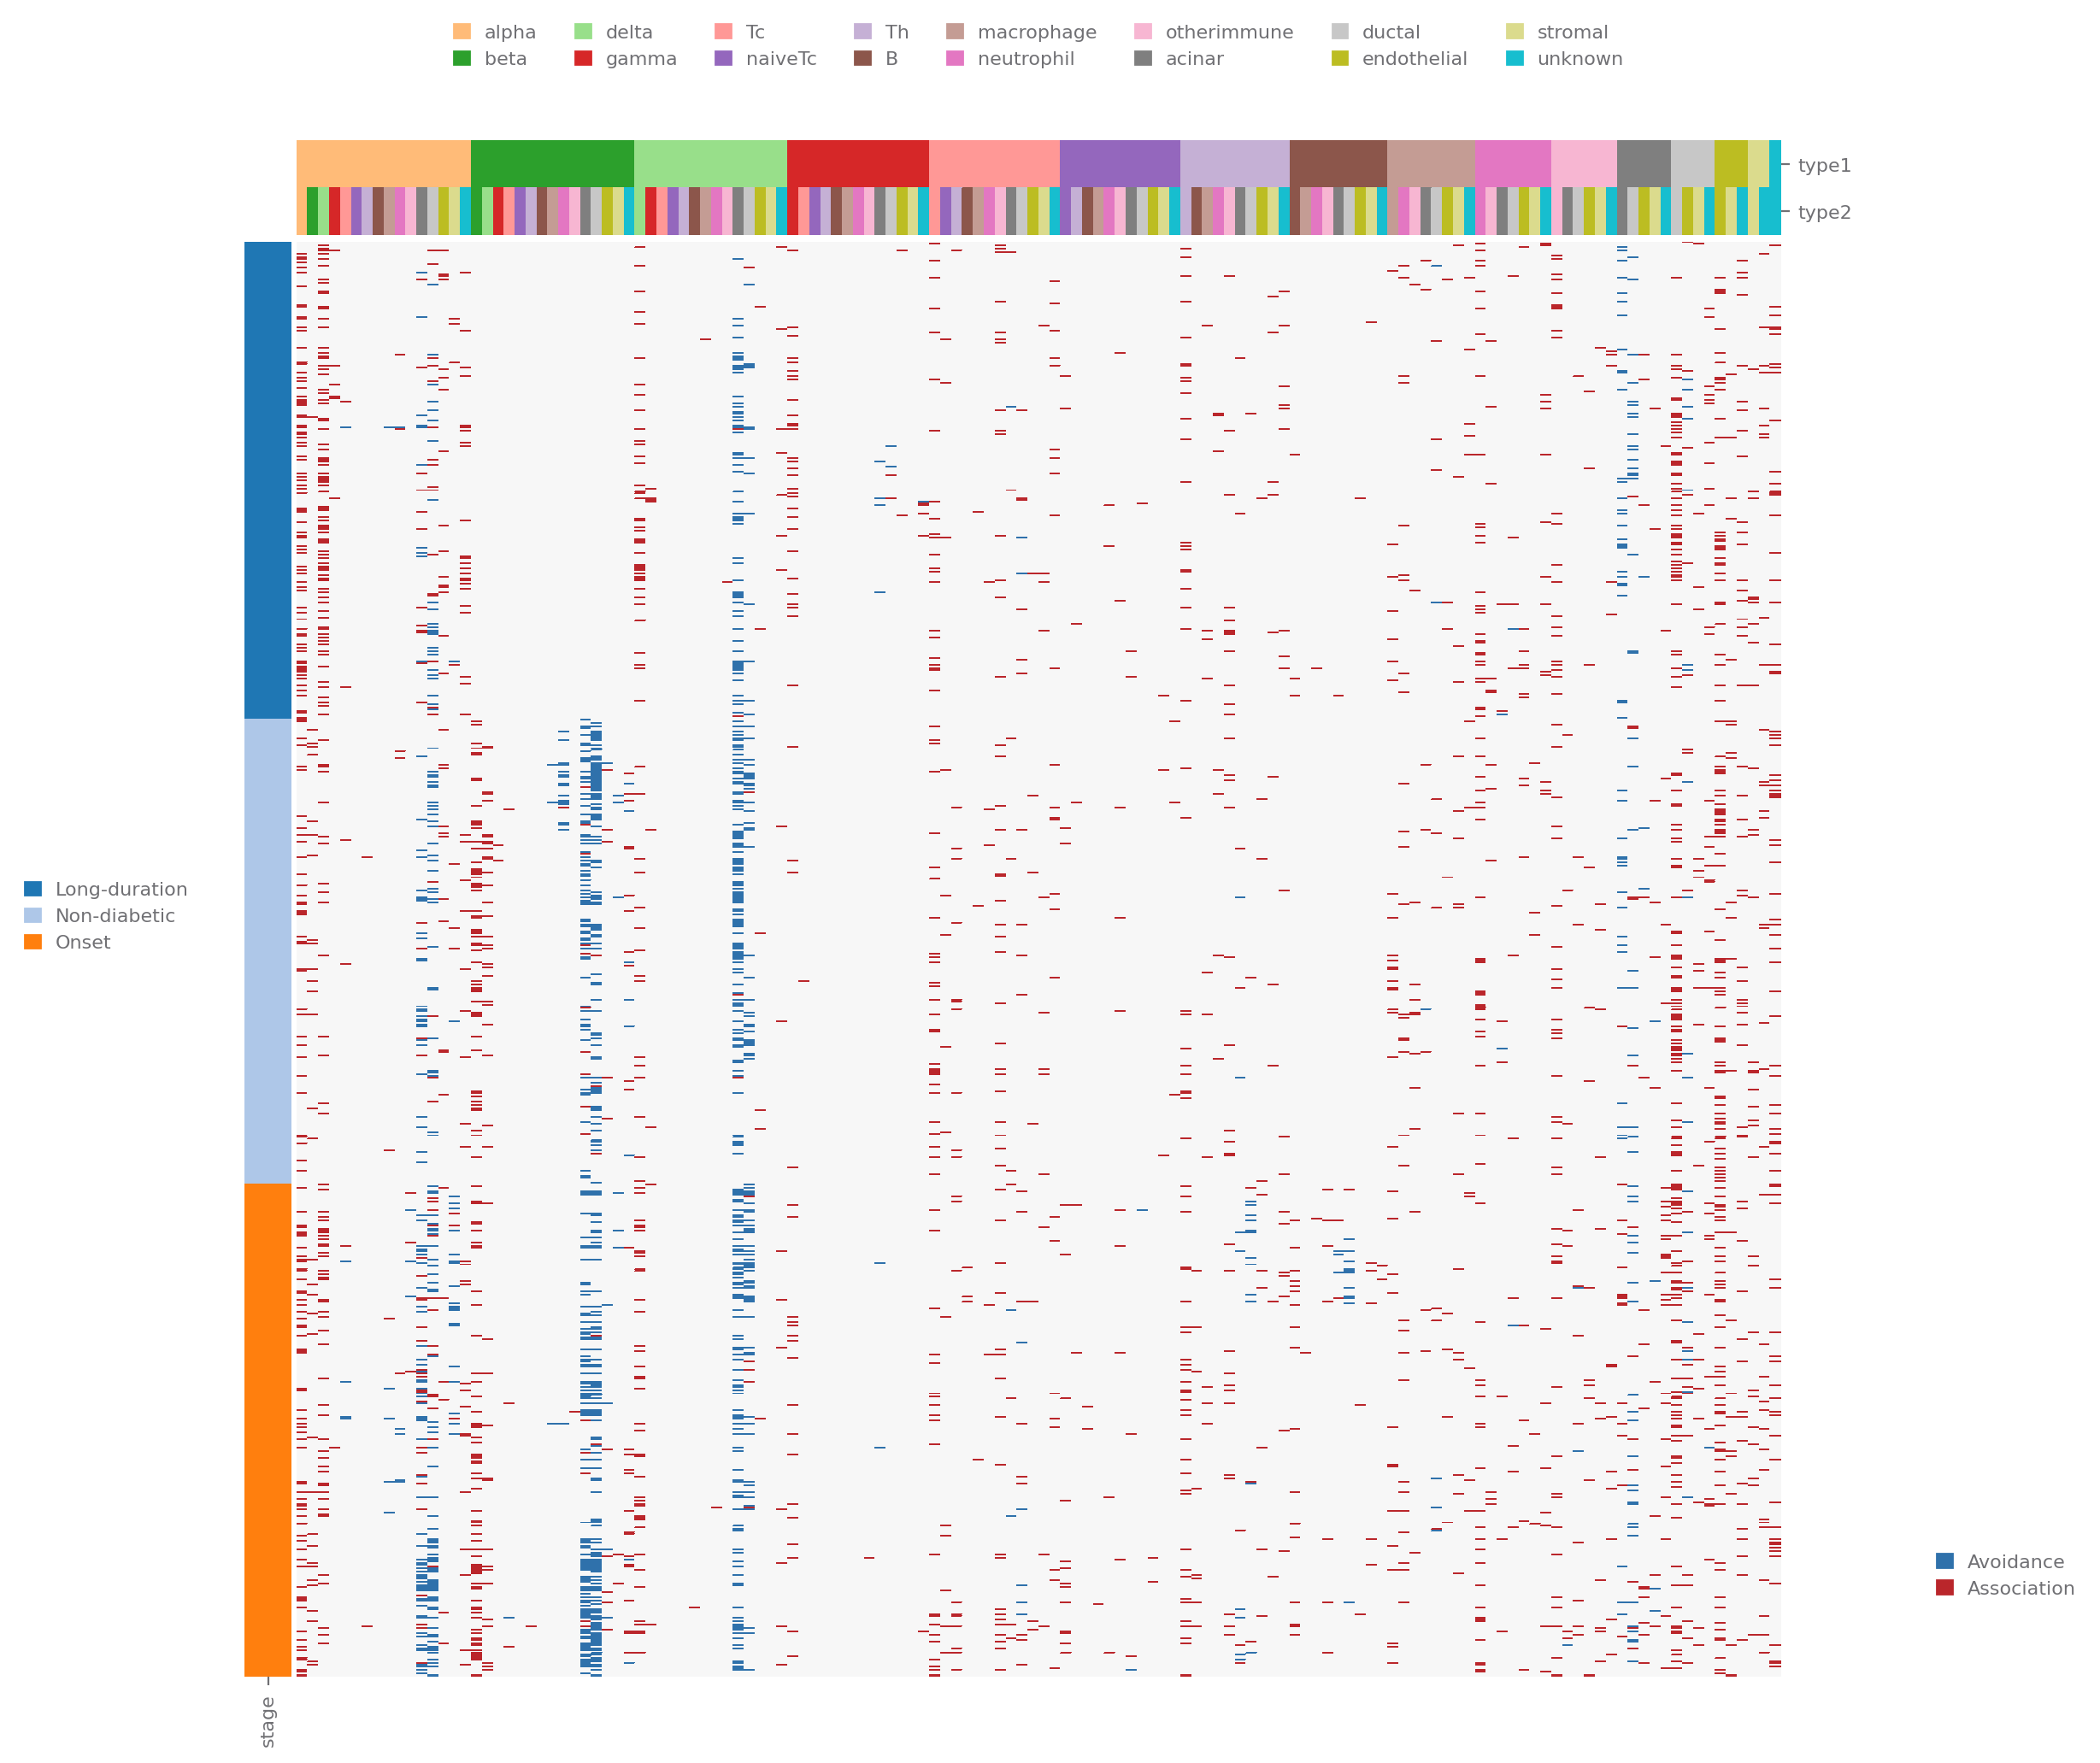

In [49]:
cell_type_order = ['alpha', 'beta', 'delta', 'gamma', 'Tc', 'naiveTc', 'Th', 'B', 'macrophage', 'neutrophil',
                  'otherimmune', 'acinar', 'ductal', 'endothelial', 'stromal', 'unknown']
sp.neighborhood_analysis(data, selected_types=cell_type_order, use="heatmap", 
                         clustermap_kwargs=dict(row_cluster=False, col_cluster=False, method="ward"))

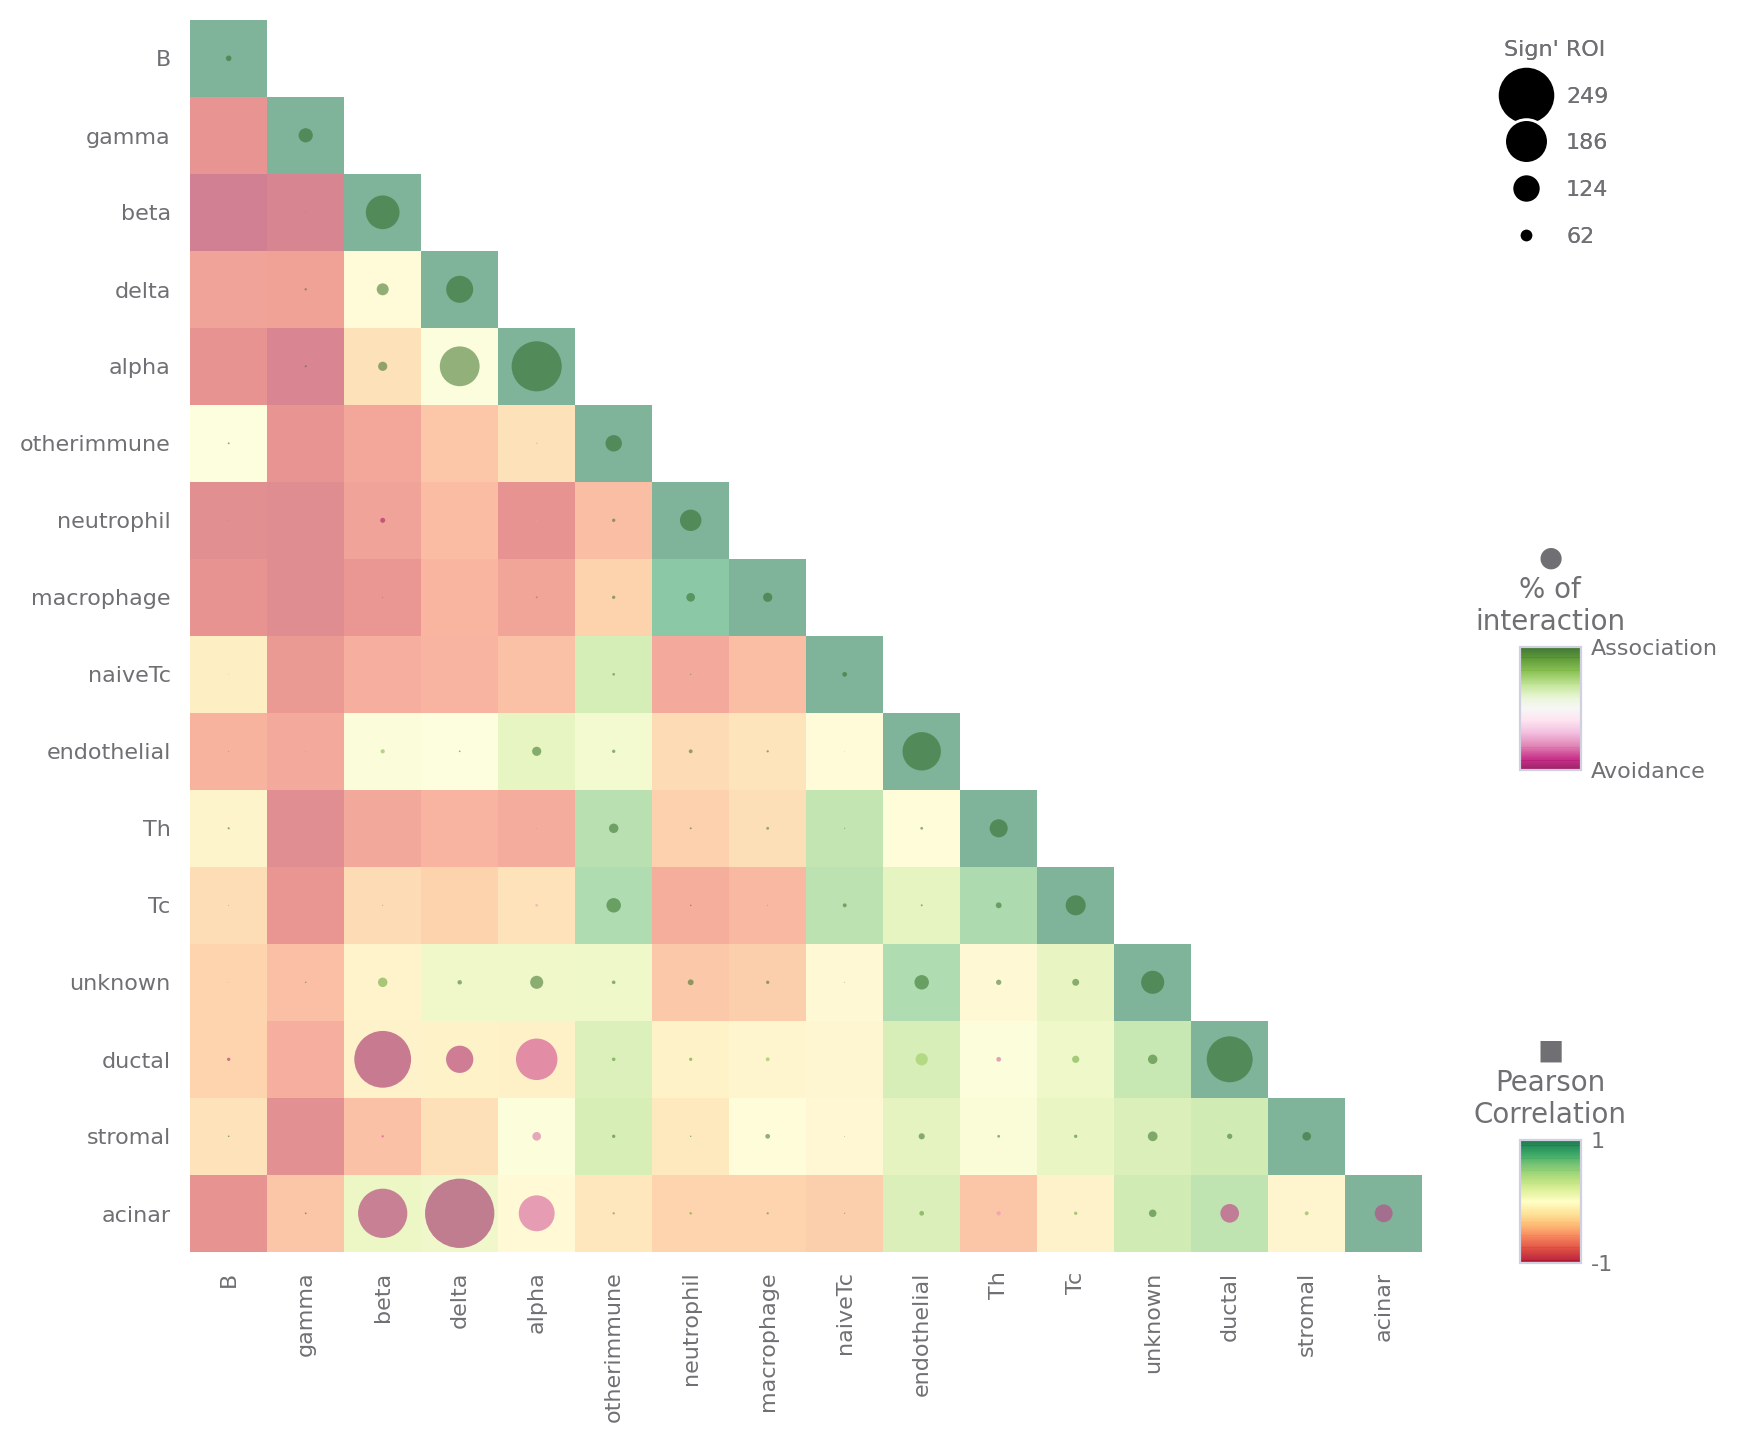

In [50]:
sp.neighborhood_analysis(data, selected_types=cell_type_order)